# 1. 정상 거래 그룹핑 확인

In [ ]:
import pandas as pd
import networkx as nx
from networkx.algorithms import community

# 0. 데이터 전처리 함수 정의
def preprocess(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.value)
    df['Timestamp'] = (df['Timestamp'] - df['Timestamp'].min()) / (df['Timestamp'].max() - df['Timestamp'].min())
    
    df['Account'] = df['From Bank'].astype(str) + '_' + df['Account']
    df['Account.1'] = df['To Bank'].astype(str) + '_' + df['Account.1']
    df = df.sort_values(by=['Account'])
    receiving_df = df[['Account.1', 'Amount Received', 'Receiving Currency']]
    paying_df = df[['Account', 'Amount Paid', 'Payment Currency']]
    receiving_df = receiving_df.rename({'Account.1': 'Account'}, axis=1)
    currency_ls = sorted(df['Receiving Currency'].unique())
    
    return df, receiving_df, paying_df, currency_ls

# 데이터 로딩 및 전처리
path = '../../../../../archive/raw/HI-Small_Trans.csv'
org_df = pd.read_csv(path)
df = org_df

df, receiving_df, paying_df, currency_ls = preprocess(df)

# 컬럼명 업데이트
df.rename({'Account': 'sender'}, axis=1 , inplace=True)
df.rename({'Account.1': 'receiver'}, axis=1, inplace=True)

# 1. 의심 거래 데이터와 정상 거래 데이터 분리
suspect_df = df[df['Is Laundering'] == 1].copy()
normal_df = df[df['Is Laundering'] == 0].copy()

# 2. 네트워크 그래프 생성
nx_graph = nx.from_pandas_edgelist(suspect_df, 'sender', 'receiver')

# 3. 커뮤니티 탐지
communities = community.greedy_modularity_communities(nx_graph)

# 커뮤니티 분석 결과
community_sizes = [len(c) for c in communities]
print("커뮤니티 사이즈 분포:", community_sizes)

# 모듈러티 점수 계산 및 출력
modularity_score = community.modularity(nx_graph, communities)
print("모듈러티 점수:", modularity_score)

# 4. 추가 분석 예시: 거래 금액 비교
average_amount_suspect = suspect_df['Amount Received'].mean()
average_amount_normal = normal_df['Amount Received'].mean()

print("의심 거래 평균 수신 금액:", average_amount_suspect)
print("정상 거래 평균 수신 금액:", average_amount_normal)



커뮤니티 사이즈 분포: [241, 167, 57, 54, 52, 50, 43, 42, 39, 37, 35, 30, 30, 28, 28, 27, 27, 27, 27, 25, 25, 24, 24, 23, 23, 23, 23, 22, 20, 19, 19, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

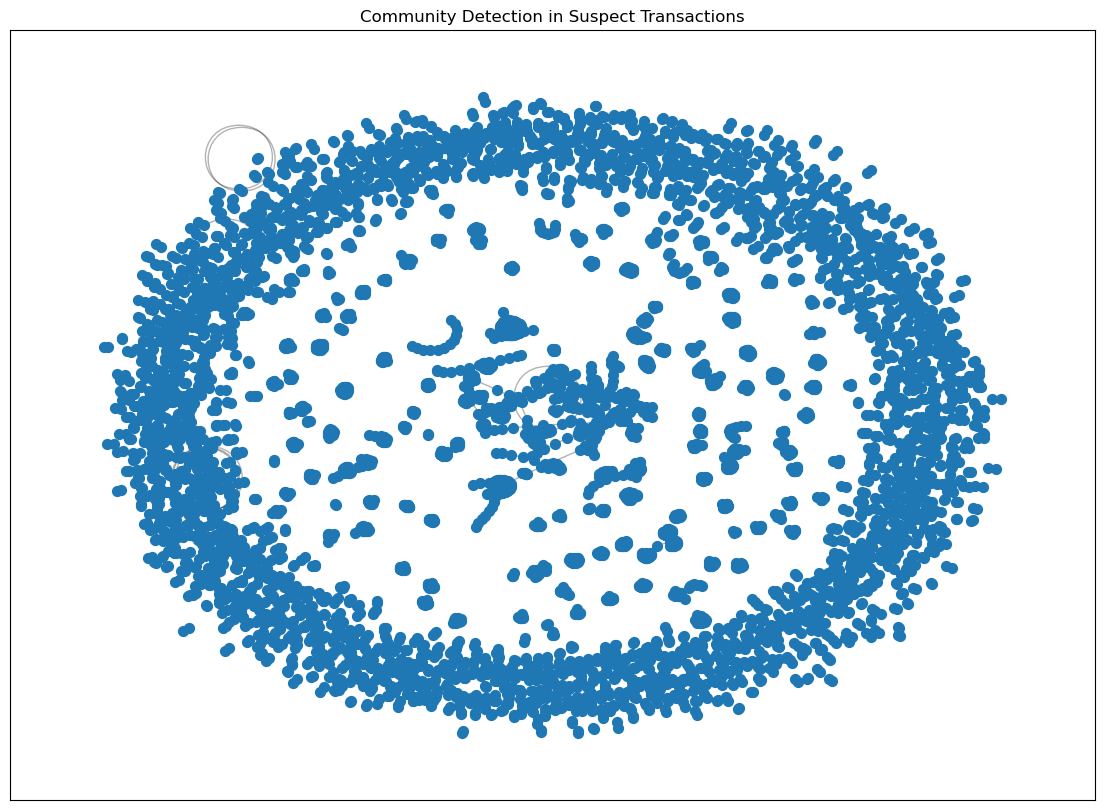

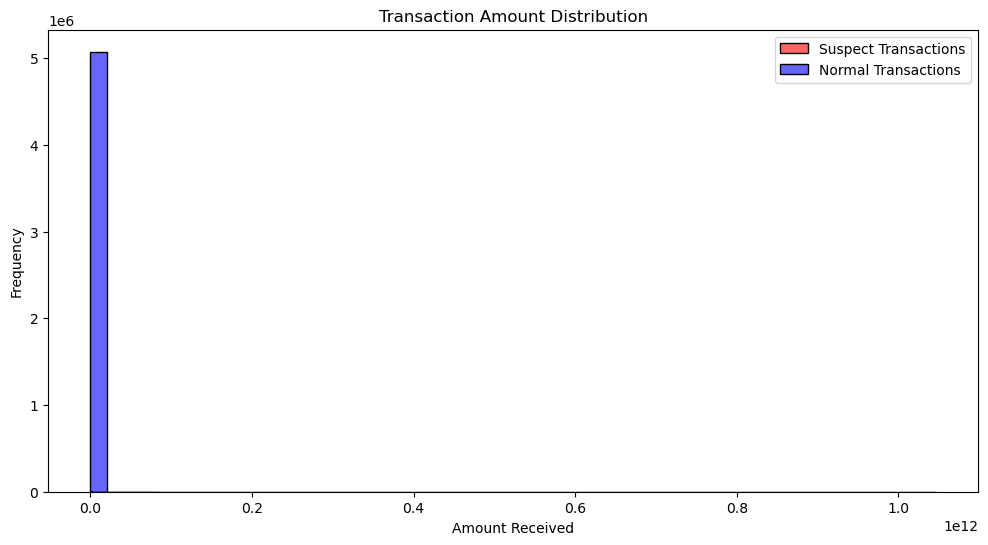

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 커뮤니티 시각화 함수 정의
def visualize_communities(graph, communities):
    pos = nx.spring_layout(graph)  # 그래프 레이아웃 초기화

    plt.figure(figsize=(14, 10))
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(graph, pos, nodelist=community, node_size=50, label=f'Community {i + 1}')

    nx.draw_networkx_edges(graph, pos, alpha=0.3)
    plt.title("Community Detection in Suspect Transactions")
    # plt.legend()
    plt.show()

# 거래 금액 분포 시각화
def plot_transaction_distribution(suspect_df, normal_df):
    plt.figure(figsize=(12, 6))
    sns.histplot(suspect_df['Amount Received'], bins=50, color='red', label='Suspect Transactions', alpha=0.6)
    sns.histplot(normal_df['Amount Received'], bins=50, color='blue', label='Normal Transactions', alpha=0.6)
    plt.xlabel('Amount Received')
    plt.ylabel('Frequency')
    plt.title("Transaction Amount Distribution")
    plt.legend()
    plt.show()

# 커뮤니티 및 거래 시각화 실행
visualize_communities(nx_graph, communities)
plot_transaction_distribution(suspect_df, normal_df)

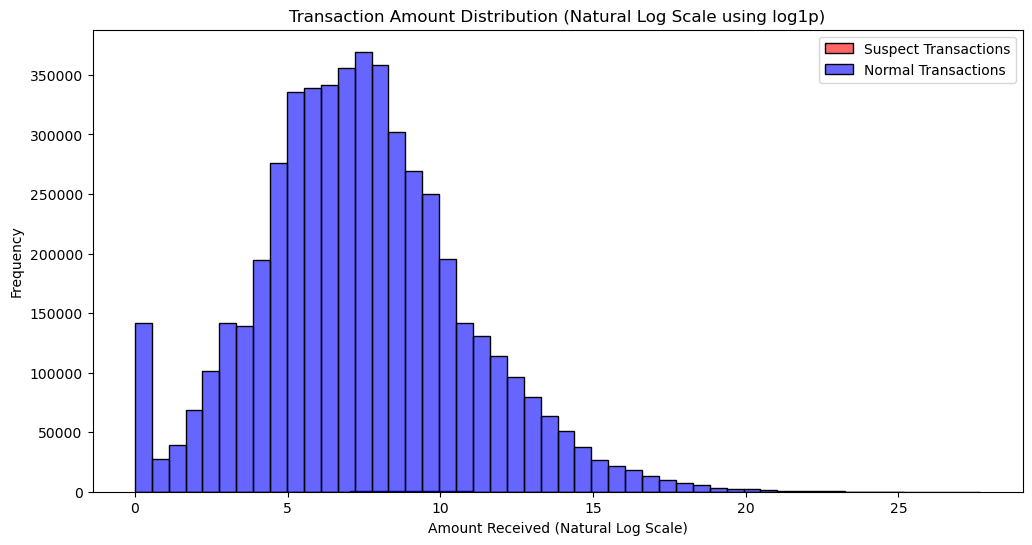

In [8]:
import numpy as np

# 거래 금액 로그 변환 (자연로그)
suspect_df['Log Amount Received'] = np.log1p(suspect_df['Amount Received'])  # 0값 처리
normal_df['Log Amount Received'] = np.log1p(normal_df['Amount Received'])  # 0값 처리

# 새로운 로그 스케일 히스토그램 코드
def plot_transaction_distribution_natural_log(suspect_df, normal_df):
    plt.figure(figsize=(12, 6))
    
    # Suspect Transactions
    sns.histplot(suspect_df['Log Amount Received'], bins=50, color='red', label='Suspect Transactions', alpha=0.6)
    
    # Normal Transactions
    sns.histplot(normal_df['Log Amount Received'], bins=50, color='blue', label='Normal Transactions', alpha=0.6)
    
    plt.xlabel('Amount Received (Natural Log Scale)')
    plt.ylabel('Frequency')
    plt.title("Transaction Amount Distribution (Natural Log Scale using log1p)")
    plt.legend()
    plt.show()

# 호출
plot_transaction_distribution_natural_log(suspect_df, normal_df)